In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [3]:
train

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131657,T0005908509,11.72,D,1.0,2.74229,A,A,3.28500,0,61.0,47,76,Male,3
131658,T0005908510,74.81,C,7.0,2.81059,C,A,0.44500,0,NaN,63,88,Male,2
131659,T0005908512,40.17,C,10.0,2.99565,B,A,3.33625,0,NaN,48,75,Female,2
131660,T0005908513,46.88,B,4.0,3.04744,A,B,4.15750,1,47.0,54,79,Male,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-null  object 
 13 

In [5]:
train.isna().sum()/len(train) * 100

Trip_ID                         0.000000
Trip_Distance                   0.000000
Type_of_Cab                    15.349911
Customer_Since_Months           4.496362
Life_Style_Index               15.336999
Confidence_Life_Style_Index    15.336999
Destination_Type                0.000000
Customer_Rating                 0.000000
Cancellation_Last_1Month        0.000000
Var1                           53.948748
Var2                            0.000000
Var3                            0.000000
Gender                          0.000000
Surge_Pricing_Type              0.000000
dtype: float64

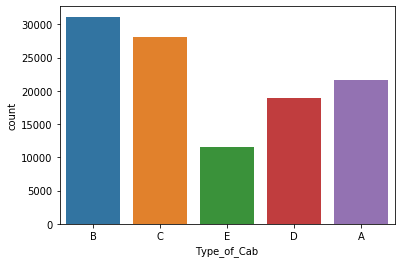

In [6]:
sns.countplot(x = 'Type_of_Cab',data = train)

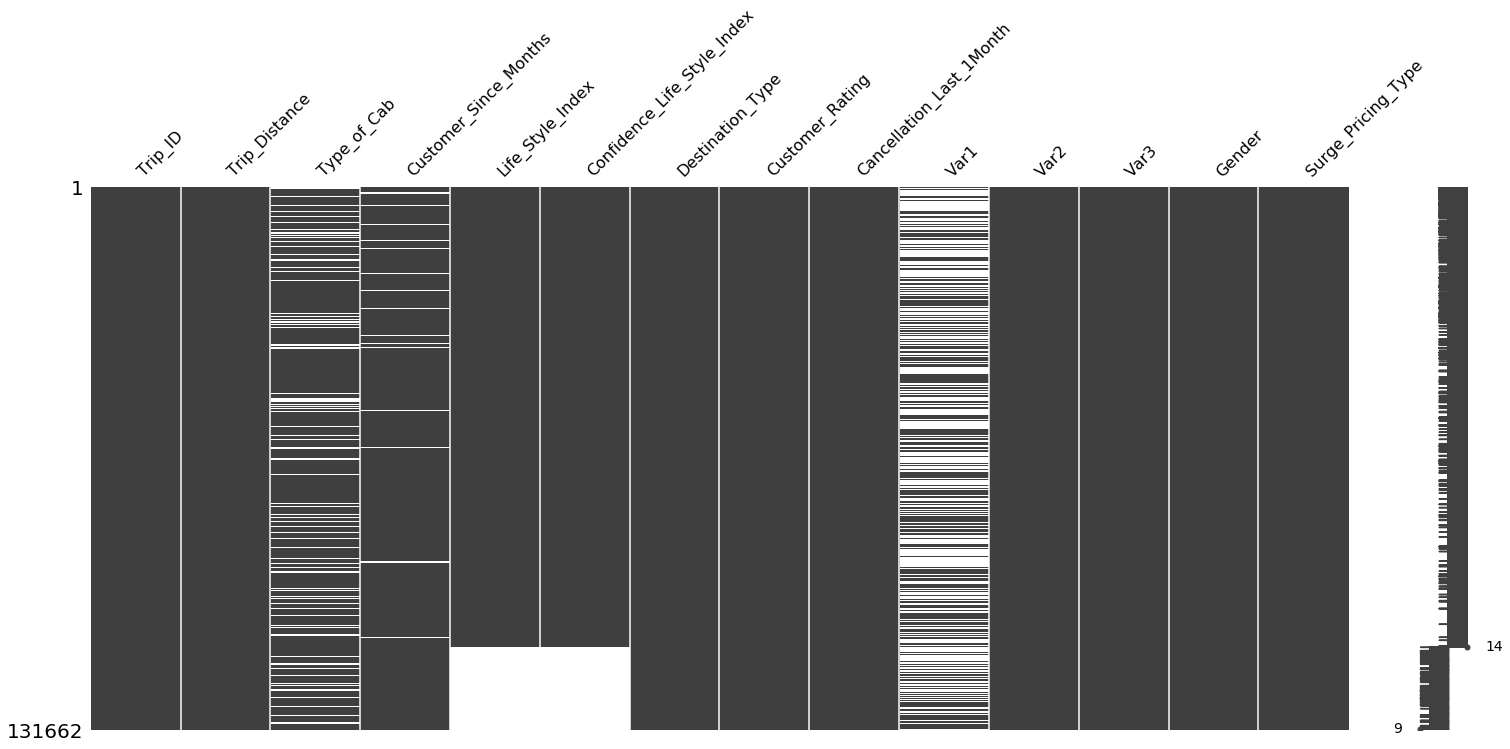

In [7]:
msno.matrix(train.sort_values(by = 'Life_Style_Index')) 
# Denotes that the columns life style index and the confidence are missing together

In [8]:
train['Gender'] = train['Gender'].replace('Female',0).replace('Male',1)
test['Gender'] = test['Gender'].replace('Female',0).replace('Male',1)
train['Gender'] = train['Gender'].astype('category')
test['Gender'] = test['Gender'].astype('category')

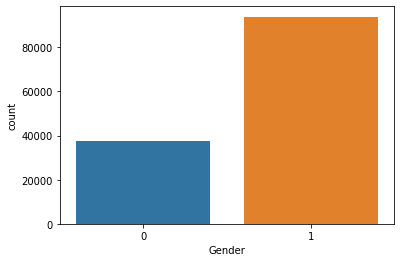

In [9]:
sns.countplot('Gender',data = train) 

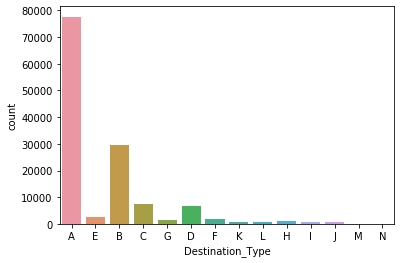

In [10]:
sns.countplot('Destination_Type',data = train) # Frequency encoding is required

In [11]:
train['Type_of_Cab'].replace(np.NaN,'Null',inplace = True)
test['Type_of_Cab'].replace(np.NaN,'Null',inplace = True)
train['Type_of_Cab'] = train['Type_of_Cab'].astype('category')
test['Type_of_Cab'] = test['Type_of_Cab'].astype('category')

In [12]:
train.groupby('Type_of_Cab')['Var1'].sum()

Type_of_Cab
A       525545.0
B       923771.0
C       871787.0
D       611114.0
E       364310.0
Null    596211.0
Name: Var1, dtype: float64

In [13]:
x = np.log(train.groupby('Destination_Type')['Trip_ID'].count()).to_dict()
train['Destination_Type'] = train['Destination_Type'].map(x)
test['Destination_Type'] = test['Destination_Type'].map(x)

In [14]:
le = LabelEncoder()
train['Type_of_Cab'] = le.fit_transform(train['Type_of_Cab'])
test['Type_of_Cab'] = le.transform(test['Type_of_Cab'])

In [15]:
train.drop('Var1',inplace = True,axis = 1)
test.drop('Var1',inplace = True,axis = 1)

In [16]:
#train['exp'] = np.exp(train['Life_Style_Index'])
train.groupby('Type_of_Cab')['Life_Style_Index'].max()

Type_of_Cab
0    4.85378
1    4.59115
2    4.07072
3    4.65904
4    4.87511
5    4.30083
Name: Life_Style_Index, dtype: float64

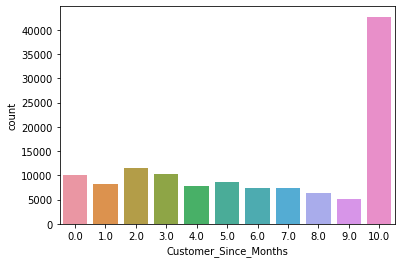

In [17]:
sns.countplot(x = 'Customer_Since_Months',data = train)
#train.info()

In [18]:
train['Customer_Since_Months'] = train['Customer_Since_Months'].fillna(6)
test['Customer_Since_Months'] = test['Customer_Since_Months'].fillna(6)

In [19]:
x,y = train['Life_Style_Index'].median(),train['Life_Style_Index'].mean()
train['Life_Style_Index'] = train['Life_Style_Index'].fillna(x)
test['Life_Style_Index'] = test['Life_Style_Index'].fillna(x)

In [20]:
train['Confidence_Life_Style_Index'] = train['Confidence_Life_Style_Index'].fillna('Null')
test['Confidence_Life_Style_Index'] = test['Confidence_Life_Style_Index'].fillna('Null')
train.groupby('Confidence_Life_Style_Index')['Trip_ID'].count()

Confidence_Life_Style_Index
A       35147
B       40355
C       35967
Null    20193
Name: Trip_ID, dtype: int64

In [21]:
a = LabelEncoder()
train['Confidence_Life_Style_Index'] = a.fit_transform(train['Confidence_Life_Style_Index'])
test['Confidence_Life_Style_Index'] = a.transform(test['Confidence_Life_Style_Index'])

In [24]:
train['ratio'] = train['Var2']/train['Var3']
test['ratio'] = test['Var2']/test['Var3']
train.drop(['Var2','Var3'],axis = 1, inplace = True)
test.drop(['Var2','Var3'],axis = 1, inplace = True)

In [29]:
train = train[['Trip_ID', 'Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months',
       'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Gender','ratio',
       'Surge_Pricing_Type']]


In [30]:
test = test[['Trip_ID', 'Trip_Distance', 'Type_of_Cab', 'Customer_Since_Months',
       'Life_Style_Index', 'Confidence_Life_Style_Index', 'Destination_Type',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Gender','ratio']]

In [42]:
train.shape,test.shape

((131662, 12), (87395, 11))

In [43]:
X = train.iloc[:,1:11].values
y = train.iloc[:,-1].values
X,y

(array([[6.77, 1, 1.0, ..., 0, 0, 0.7666666666666667],
        [29.47, 1, 10.0, ..., 0, 1, 0.717948717948718],
        [41.58, 5, 10.0, ..., 2, 1, 0.7272727272727273],
        ...,
        [40.17, 2, 10.0, ..., 0, 0, 0.64],
        [46.88, 1, 4.0, ..., 1, 1, 0.6835443037974683],
        [31.96, 0, 7.0, ..., 1, 1, 0.6705882352941176]], dtype=object),
 array([2, 2, 2, ..., 2, 2, 1], dtype=int64))

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [45]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_train,y_train)

1.0

In [46]:
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.6885490771918277

<BarContainer object of 10 artists>

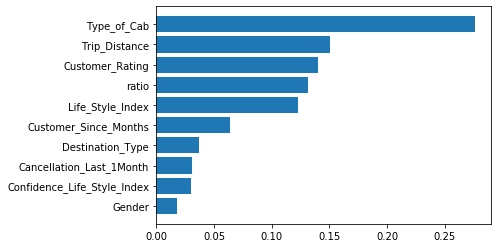

In [47]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,rf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [49]:
test_X = test.iloc[:,1:11].values
test_y = rf.predict(test_X)

sub_rf = pd.DataFrame()
sub_rf['Trip_ID'] = submission['Trip_ID']
sub_rf['Surge_Pricing_Type'] = test_y
sub_rf.to_csv('Random_Forest_New_Data.csv',index = False)

In [60]:
parameters = { 'max_features' : [3,4,5],
              'n_estimators' : [120],
              'min_samples_leaf' : [20],
              'max_depth' :[3,5,7]}
random_grid = GridSearchCV(rf, parameters, cv = 5,n_jobs = -1,verbose = 10)
random_grid.fit(X_train,y_train)
random_grid.best_score_,random_grid.best_params_,random_grid.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:  1.3min remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  1.5min remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min finished


(0.6887580059558792,
 {'max_depth': 7,
  'max_features': 5,
  'min_samples_leaf': 20,
  'n_estimators': 120},
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=7, max_features=5,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=20, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=120,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))

In [61]:
y_pred = random_grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

0.6913845920149877

<BarContainer object of 10 artists>

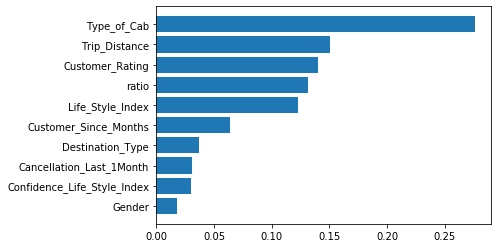

In [62]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,rf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [64]:
test_X = test.iloc[:,1:11].values
test_y = random_grid.best_estimator_.predict(test_X)

sub_rf = pd.DataFrame()
sub_rf['Trip_ID'] = submission['Trip_ID']
sub_rf['Surge_Pricing_Type'] = test_y
sub_rf.to_csv('Random_Forest_New_Data_2.csv',index = False)

In [ ]:
# Iteration 1 rf:
parameters = { 'max_depth':[4,6],'n_estimators':[100,200],'min_samples_leaf': [10,50,100,200]}
random_grid = GridSearchCV(rf, parameters, cv = 5,n_jobs = -1)
random_grid.fit(X_train,y_train)
print('Best score:',random_grid.best_score_)
print('Best Params:',random_grid.best_params_)

In [ ]:
y_pred = random_grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred) #0.6861945872047394

In [ ]:
# Iteration 2
parameters = {'max_depth':[4,6],
              'n_estimators':[100,200],
              'min_samples_leaf': [10,50,100,200]}
random_grid = GridSearchCV(rf, parameters, cv = StratifiedKFold(n_splits = 5, shuffle = True),n_jobs = -1)
random_grid.fit(X_train,y_train)
print('Best score:',random_grid.best_score_)
print('Best Params:',random_grid.best_params_)

In [ ]:
y_pred = random_grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred) #0.6861945872047394

In [ ]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,rf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [ ]:
test_X = test.iloc[:,1:11].values
test_y = random_grid.best_estimator_.predict(test_X)

sub_rf = pd.DataFrame()
sub_rf['Trip_ID'] = submission['Trip_ID']
sub_rf['Surge_Pricing_Type'] = test_y
sub_rf.to_csv('Adaboost_1.csv',ignore_index = True)

In [65]:
clf = AdaBoostClassifier(random_state = 41)
clf.fit(X_train,y_train)

print('Accuracy on train:',clf.score(X_train,y_train))
print('Accuracy on test:',clf.score(X_test,y_test))

Accuracy on train: 0.6908303766153445
Accuracy on test: 0.6907010304058331


In [66]:
parameters = [{'learning_rate' : [0.25,0.5,0.75,1],
               'n_estimators' : [150,200,225,250]}]
grid_search = GridSearchCV(estimator = clf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True) 
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_,grid.best_estimator_

({'learning_rate': 1, 'n_estimators': 150},
 0.6902119554508973,
 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                    n_estimators=150, random_state=41))

In [67]:
y_pred = grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

0.6918909339476949

In [68]:
test_X = test.iloc[:,1:11].values
test_y = grid.best_estimator_.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
sub_ada.to_csv('Adaboost_grid2.csv',index = False)

<BarContainer object of 10 artists>

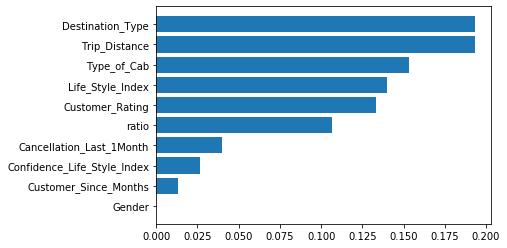

In [69]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,grid.best_estimator_.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [70]:
xgclf = XGBClassifier(random_state = 41)
xgclf.fit(X_train,y_train)

print('Accuracy on train:',clf.score(X_train,y_train))
print('Accuracy on test:',clf.score(X_test,y_test))

Accuracy on train: 0.6908303766153445
Accuracy on test: 0.6907010304058331


In [72]:
parameters = [{'learning_rate' : [0.2,0.3,0.4],
               'n_estimators' : [75,100,150],
               'max_depth' : [3,5,7],
               'min_child_weight':[1,3,4]}]
grid_search = GridSearchCV(estimator = xgclf,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           n_jobs = -1,
                           cv = StratifiedKFold(n_splits = 5, shuffle = True) 
)
grid = grid_search.fit(X_train,y_train)
grid.best_params_, grid.best_score_,grid.best_estimator_

({'learning_rate': 0.2,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 75},
 0.6986534760885142,
 XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints=None,
               learning_rate=0.2, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=75, n_jobs=0, num_parallel_tree=1,
               objective='multi:softprob', random_state=41, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=None, subsample=1,
               tree_method=None, validate_parameters=False, verbosity=None))

In [73]:
y_pred = grid.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

0.6991569406820426

In [74]:
test_X = test.iloc[:,1:11].values
test_y = grid.best_estimator_.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
sub_ada.to_csv('xg_New_Data_grid_2.csv',index = False)

<BarContainer object of 10 artists>

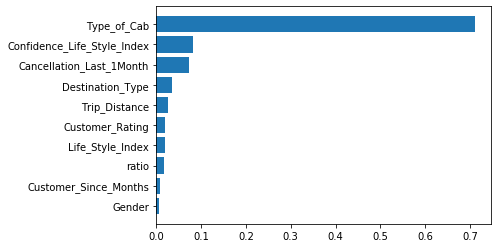

In [75]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,grid.best_estimator_.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [76]:
catclf = CatBoostClassifier(random_state = 41)
catclf.fit(X_train,y_train)

print('Accuracy on train:',catclf.score(X_train,y_train))
print('Accuracy on test:',catclf.score(X_test,y_test))

Learning rate set to 0.099659
0:	learn: 1.0369561	total: 218ms	remaining: 3m 37s
1:	learn: 0.9891018	total: 299ms	remaining: 2m 29s
2:	learn: 0.9496186	total: 345ms	remaining: 1m 54s
3:	learn: 0.9179630	total: 390ms	remaining: 1m 37s
4:	learn: 0.8916782	total: 428ms	remaining: 1m 25s
5:	learn: 0.8713753	total: 462ms	remaining: 1m 16s
6:	learn: 0.8530949	total: 501ms	remaining: 1m 11s
7:	learn: 0.8377580	total: 545ms	remaining: 1m 7s
8:	learn: 0.8244563	total: 591ms	remaining: 1m 5s
9:	learn: 0.8139653	total: 645ms	remaining: 1m 3s
10:	learn: 0.8042357	total: 695ms	remaining: 1m 2s
11:	learn: 0.7959076	total: 739ms	remaining: 1m
12:	learn: 0.7888858	total: 784ms	remaining: 59.5s
13:	learn: 0.7827166	total: 828ms	remaining: 58.3s
14:	learn: 0.7778966	total: 879ms	remaining: 57.8s
15:	learn: 0.7729863	total: 928ms	remaining: 57.1s
16:	learn: 0.7684836	total: 990ms	remaining: 57.2s
17:	learn: 0.7646898	total: 1.05s	remaining: 57.1s
18:	learn: 0.7614648	total: 1.09s	remaining: 56.2s
19:	lea

164:	learn: 0.6964405	total: 7.57s	remaining: 38.3s
165:	learn: 0.6963701	total: 7.61s	remaining: 38.2s
166:	learn: 0.6963330	total: 7.65s	remaining: 38.2s
167:	learn: 0.6962483	total: 7.69s	remaining: 38.1s
168:	learn: 0.6961433	total: 7.73s	remaining: 38s
169:	learn: 0.6960561	total: 7.78s	remaining: 38s
170:	learn: 0.6959487	total: 7.83s	remaining: 38s
171:	learn: 0.6958993	total: 7.89s	remaining: 38s
172:	learn: 0.6957941	total: 7.95s	remaining: 38s
173:	learn: 0.6956842	total: 8s	remaining: 38s
174:	learn: 0.6955725	total: 8.05s	remaining: 37.9s
175:	learn: 0.6954696	total: 8.1s	remaining: 37.9s
176:	learn: 0.6953773	total: 8.14s	remaining: 37.9s
177:	learn: 0.6952667	total: 8.19s	remaining: 37.8s
178:	learn: 0.6952083	total: 8.23s	remaining: 37.8s
179:	learn: 0.6951029	total: 8.28s	remaining: 37.7s
180:	learn: 0.6950403	total: 8.33s	remaining: 37.7s
181:	learn: 0.6949349	total: 8.38s	remaining: 37.7s
182:	learn: 0.6948203	total: 8.42s	remaining: 37.6s
183:	learn: 0.6947455	total:

323:	learn: 0.6836256	total: 14.9s	remaining: 31s
324:	learn: 0.6835549	total: 14.9s	remaining: 31s
325:	learn: 0.6834973	total: 15s	remaining: 30.9s
326:	learn: 0.6834285	total: 15s	remaining: 30.9s
327:	learn: 0.6833735	total: 15s	remaining: 30.8s
328:	learn: 0.6833050	total: 15.1s	remaining: 30.8s
329:	learn: 0.6832156	total: 15.1s	remaining: 30.7s
330:	learn: 0.6831141	total: 15.2s	remaining: 30.7s
331:	learn: 0.6830696	total: 15.2s	remaining: 30.6s
332:	learn: 0.6830013	total: 15.3s	remaining: 30.6s
333:	learn: 0.6829726	total: 15.3s	remaining: 30.6s
334:	learn: 0.6828801	total: 15.4s	remaining: 30.5s
335:	learn: 0.6828100	total: 15.4s	remaining: 30.5s
336:	learn: 0.6827726	total: 15.5s	remaining: 30.4s
337:	learn: 0.6827487	total: 15.5s	remaining: 30.4s
338:	learn: 0.6827046	total: 15.6s	remaining: 30.3s
339:	learn: 0.6826416	total: 15.6s	remaining: 30.3s
340:	learn: 0.6825513	total: 15.7s	remaining: 30.3s
341:	learn: 0.6824909	total: 15.7s	remaining: 30.3s
342:	learn: 0.6824498	

483:	learn: 0.6733261	total: 22.1s	remaining: 23.6s
484:	learn: 0.6732945	total: 22.1s	remaining: 23.5s
485:	learn: 0.6731941	total: 22.2s	remaining: 23.5s
486:	learn: 0.6731131	total: 22.2s	remaining: 23.4s
487:	learn: 0.6730484	total: 22.3s	remaining: 23.4s
488:	learn: 0.6729860	total: 22.3s	remaining: 23.3s
489:	learn: 0.6729374	total: 22.4s	remaining: 23.3s
490:	learn: 0.6728770	total: 22.4s	remaining: 23.2s
491:	learn: 0.6728364	total: 22.4s	remaining: 23.2s
492:	learn: 0.6727791	total: 22.5s	remaining: 23.1s
493:	learn: 0.6727192	total: 22.5s	remaining: 23.1s
494:	learn: 0.6726308	total: 22.6s	remaining: 23.1s
495:	learn: 0.6725655	total: 22.7s	remaining: 23s
496:	learn: 0.6724863	total: 22.7s	remaining: 23s
497:	learn: 0.6724306	total: 22.7s	remaining: 22.9s
498:	learn: 0.6723906	total: 22.8s	remaining: 22.9s
499:	learn: 0.6723541	total: 22.8s	remaining: 22.8s
500:	learn: 0.6723194	total: 22.9s	remaining: 22.8s
501:	learn: 0.6722571	total: 22.9s	remaining: 22.7s
502:	learn: 0.67

643:	learn: 0.6645950	total: 29.4s	remaining: 16.2s
644:	learn: 0.6645233	total: 29.4s	remaining: 16.2s
645:	learn: 0.6644736	total: 29.5s	remaining: 16.2s
646:	learn: 0.6644357	total: 29.5s	remaining: 16.1s
647:	learn: 0.6643686	total: 29.6s	remaining: 16.1s
648:	learn: 0.6643140	total: 29.6s	remaining: 16s
649:	learn: 0.6642599	total: 29.7s	remaining: 16s
650:	learn: 0.6642015	total: 29.7s	remaining: 15.9s
651:	learn: 0.6641599	total: 29.8s	remaining: 15.9s
652:	learn: 0.6641009	total: 29.8s	remaining: 15.8s
653:	learn: 0.6640557	total: 29.9s	remaining: 15.8s
654:	learn: 0.6640016	total: 29.9s	remaining: 15.7s
655:	learn: 0.6639417	total: 29.9s	remaining: 15.7s
656:	learn: 0.6638901	total: 30s	remaining: 15.6s
657:	learn: 0.6638439	total: 30s	remaining: 15.6s
658:	learn: 0.6637881	total: 30.1s	remaining: 15.6s
659:	learn: 0.6637217	total: 30.1s	remaining: 15.5s
660:	learn: 0.6636787	total: 30.2s	remaining: 15.5s
661:	learn: 0.6636189	total: 30.2s	remaining: 15.4s
662:	learn: 0.663561

804:	learn: 0.6562149	total: 36.6s	remaining: 8.87s
805:	learn: 0.6561657	total: 36.6s	remaining: 8.82s
806:	learn: 0.6561199	total: 36.7s	remaining: 8.77s
807:	learn: 0.6560622	total: 36.7s	remaining: 8.73s
808:	learn: 0.6559984	total: 36.8s	remaining: 8.68s
809:	learn: 0.6559347	total: 36.8s	remaining: 8.64s
810:	learn: 0.6558845	total: 36.9s	remaining: 8.59s
811:	learn: 0.6558190	total: 36.9s	remaining: 8.55s
812:	learn: 0.6557811	total: 37s	remaining: 8.5s
813:	learn: 0.6557196	total: 37s	remaining: 8.46s
814:	learn: 0.6556394	total: 37.1s	remaining: 8.41s
815:	learn: 0.6555789	total: 37.1s	remaining: 8.37s
816:	learn: 0.6555256	total: 37.1s	remaining: 8.32s
817:	learn: 0.6554639	total: 37.2s	remaining: 8.27s
818:	learn: 0.6553987	total: 37.2s	remaining: 8.22s
819:	learn: 0.6553589	total: 37.3s	remaining: 8.18s
820:	learn: 0.6553136	total: 37.3s	remaining: 8.13s
821:	learn: 0.6552372	total: 37.4s	remaining: 8.09s
822:	learn: 0.6551991	total: 37.4s	remaining: 8.04s
823:	learn: 0.655

963:	learn: 0.6482051	total: 43.9s	remaining: 1.64s
964:	learn: 0.6481535	total: 44s	remaining: 1.59s
965:	learn: 0.6480697	total: 44s	remaining: 1.55s
966:	learn: 0.6480163	total: 44s	remaining: 1.5s
967:	learn: 0.6479679	total: 44.1s	remaining: 1.46s
968:	learn: 0.6479318	total: 44.1s	remaining: 1.41s
969:	learn: 0.6478763	total: 44.2s	remaining: 1.37s
970:	learn: 0.6478309	total: 44.2s	remaining: 1.32s
971:	learn: 0.6477866	total: 44.3s	remaining: 1.27s
972:	learn: 0.6477339	total: 44.3s	remaining: 1.23s
973:	learn: 0.6476902	total: 44.4s	remaining: 1.18s
974:	learn: 0.6476420	total: 44.4s	remaining: 1.14s
975:	learn: 0.6475980	total: 44.5s	remaining: 1.09s
976:	learn: 0.6475468	total: 44.5s	remaining: 1.05s
977:	learn: 0.6474836	total: 44.6s	remaining: 1s
978:	learn: 0.6474135	total: 44.6s	remaining: 957ms
979:	learn: 0.6473834	total: 44.6s	remaining: 911ms
980:	learn: 0.6473246	total: 44.7s	remaining: 865ms
981:	learn: 0.6472825	total: 44.7s	remaining: 820ms
982:	learn: 0.6472467	

In [77]:
test_X = test.iloc[:,1:11].values
test_y = catclf.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
sub_ada.to_csv('cat_default_New_Data.csv',index = False)

<BarContainer object of 10 artists>

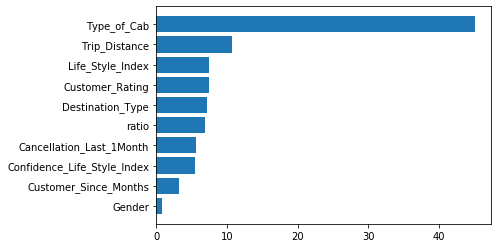

In [78]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,catclf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])

In [79]:
lgbclf = LGBMClassifier(random_state = 41)
lgbclf.fit(X_train,y_train)

print('Accuracy on train:',lgbclf.score(X_train,y_train))
print('Accuracy on test:',lgbclf.score(X_test,y_test))

Accuracy on train: 0.7112507188351074
Accuracy on test: 0.6989290868123244


In [80]:
test_X = test.iloc[:,1:12].values
test_y = lgbclf.predict(test_X)

sub_ada = pd.DataFrame()
sub_ada['Trip_ID'] = submission['Trip_ID']
sub_ada['Surge_Pricing_Type'] = test_y
sub_ada.to_csv('LightGBM_default_New_Data.csv',index = False)

<BarContainer object of 10 artists>

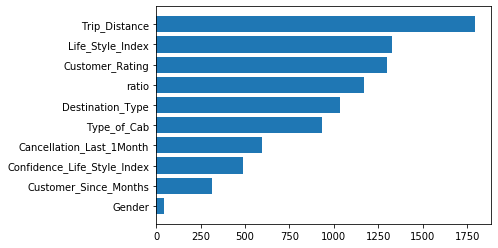

In [81]:
fimp = pd.DataFrame(zip(train.drop(['Surge_Pricing_Type','Trip_ID'],axis = 1).columns,lgbclf.feature_importances_))
fimp.columns = ['features','Score']

sfimp =fimp.sort_values(by = 'Score')

plt.barh(sfimp['features'],sfimp['Score'])